In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input 
from tensorflow.keras.applications import InceptionV3
import matplotlib.pyplot as plt
#from sklearn.metrics import plot_confusion_matrix bu satır sıkıntıya sokabilir
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping 
import cv2
#import numpy as np
import seaborn as sns
import os
import random
#import pandas as pd  

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
"""
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [17]:
#train data 
train_data = ImageDataGenerator(
    rescale = 1./255,
    featurewise_center = False,
    featurewise_std_normalization = False, 
    rotation_range = 20, 
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = .1,
    horizontal_flip = True
)
test_data = ImageDataGenerator(rescale = 1./255)

In [18]:
X_train_gen = train_data.flow_from_directory(
    "/kaggle/input/fer2013vgg19-early/train/train",
    target_size = (48, 48),
    batch_size = 64,
    class_mode = "categorical"
)
X_val = test_data.flow_from_directory(
    "/kaggle/input/fer2013vgg19-early/test/test",
    batch_size = 64,
    target_size = (48, 48),
    class_mode = "categorical"
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
from sklearn.utils import class_weight
from keras.callbacks import ModelCheckpoint

class_weights = class_weight.compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(X_train_gen.classes),
    y = X_train_gen.classes )
num_classes = 7
keys = range(num_classes)
values = class_weights.copy()
class_weights = dict(zip(keys, values))
print(class_weights)

{0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [24]:
base_model = VGG19(
    include_top = False,
    weights = None,
    input_shape = (48, 48, 3))
base_model.load_weights("/kaggle/input/nn-vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5")
for layer in base_model.layers[:10]:
    layer.trainable = False

In [25]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(0.5)) #regularization artışı
model.add(Dense(units = 7, activation = 'softmax'))

In [26]:
model.summary() #model özeti

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                32832     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 7)                 455       
                                                                 
Total params: 20,057,671
Trainable params: 18,322,183
Non-trainable params: 1,735,488
_________________________________________________________________


In [21]:
early_stop = EarlyStopping(monitor = "val_acc", mode = "max", patience = 5, restore_best_weights = True)

In [28]:
optimizer_1 = SGD(learning_rate = 0.01) #stochastic gratient descent
model.compile(optimizer = optimizer_1, loss = "categorical_crossentropy", metrics = ["acc"])

In [29]:
history = model.fit(
    X_train_gen,
    epochs = 70,
    verbose = 1,
    callbacks = early_stop,
    class_weight = class_weights,
    validation_data = X_val
)

Epoch 1/70
449/449 [==============================] - 64s 139ms/step - loss: 1.9031 - acc: 0.2073 - val_loss: 1.7683 - val_acc: 0.3066
Epoch 2/70
449/449 [==============================] - 62s 138ms/step - loss: 1.7658 - acc: 0.3015 - val_loss: 1.5315 - val_acc: 0.4376
Epoch 3/70
449/449 [==============================] - 62s 137ms/step - loss: 1.6500 - acc: 0.3666 - val_loss: 1.5411 - val_acc: 0.4120
Epoch 4/70
449/449 [==============================] - 62s 139ms/step - loss: 1.5618 - acc: 0.4020 - val_loss: 1.3895 - val_acc: 0.4707
Epoch 5/70
449/449 [==============================] - 62s 139ms/step - loss: 1.4962 - acc: 0.4314 - val_loss: 1.3294 - val_acc: 0.4954
Epoch 6/70
449/449 [==============================] - 61s 136ms/step - loss: 1.4379 - acc: 0.4488 - val_loss: 1.3446 - val_acc: 0.4994
Epoch 7/70
449/449 [==============================] - 62s 137ms/step - loss: 1.4095 - acc: 0.4607 - val_loss: 1.2927 - val_acc: 0.5107
Epoch 8/70
449/449 [==============================] - 6

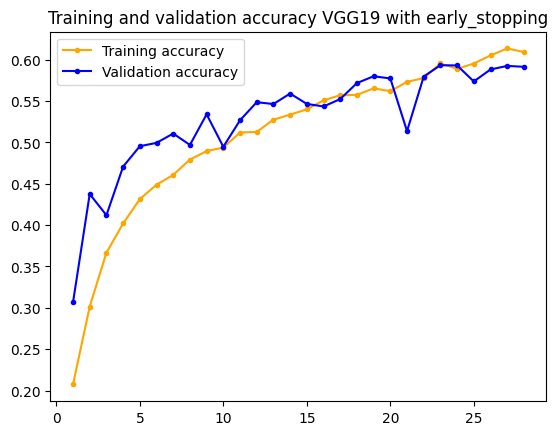

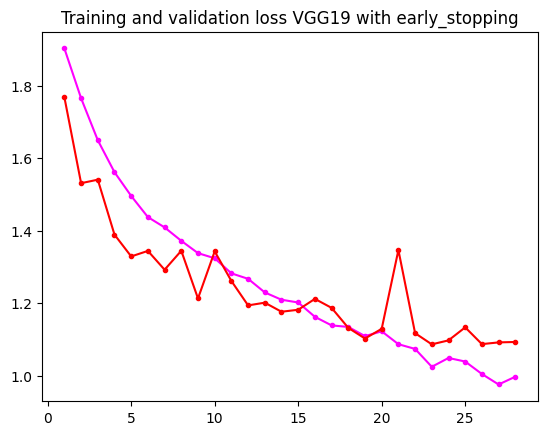

In [30]:
#history 
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.title("Training and validation accuracy VGG19 with early_stopping")
plt.plot(epochs, acc, 'orange', marker = '.', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'blue', marker = '.', label = 'Validation accuracy')
plt.legend()

plt.figure()
plt.title("Training and validation loss VGG19 with early_stopping")
plt.plot(epochs, loss, 'magenta', marker = '.', label = 'Training loss')
plt.plot(epochs, val_loss, 'red', marker = '.', label = 'Validation loss')

In [35]:
test_data = []
test_data_dir = "/kaggle/input/ferplusvgg/test"
categories = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
def create_test_data():
    for cat in categories:
        path = os.path.join(test_data_dir, cat)
        class_num = categories.index(cat)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (48, 48))
            test_data.append([new_array, class_num])

In [36]:
create_test_data()

In [39]:
random.shuffle(test_data)
X_test = []
y_test = []
for features, labels in test_data:
    X_test.append(features)
    y_test.append(labels)
X_test = np.array(X_test).reshape(7048, 48, 48, 3)
y_test = np.array(y_test)

In [40]:
X_test = X_test/255.0

221/221 [==============================] - 4s 16ms/step


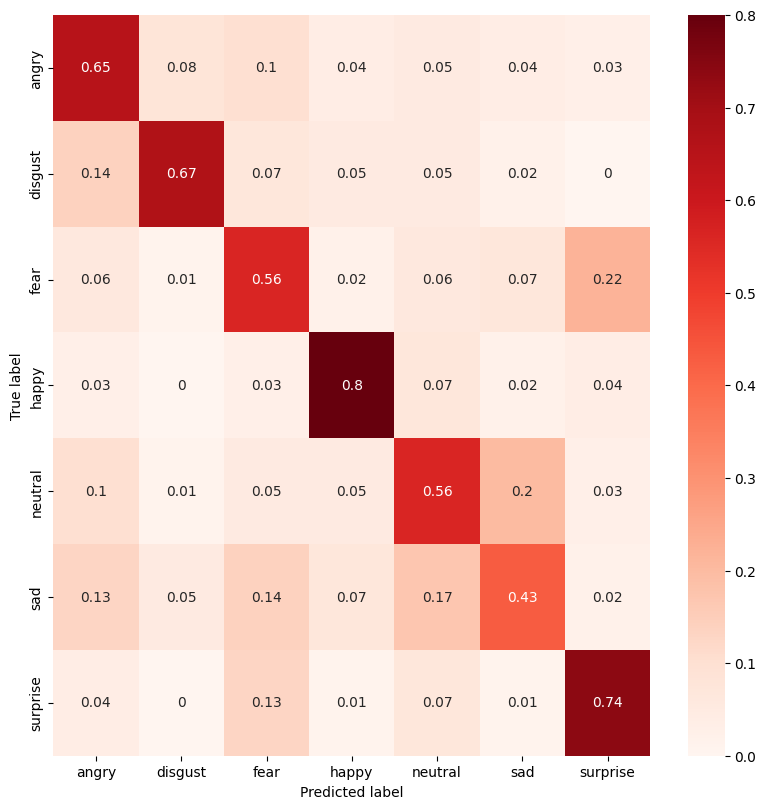

In [41]:
y_predict = model.predict(X_test)
y_true = y_test
res = tf.math.confusion_matrix(y_true, y_predict.argmax(axis = 1)).numpy()
class_names = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
con_mat_norm = np.around(res.astype('float')/res.sum(axis = 1)[:, np.newaxis], decimals = 2)
con_mat_df = pd.DataFrame(con_mat_norm, index = class_names, columns = class_names)

figure = plt.figure(figsize = (8,8))
sns.heatmap(con_mat_df, annot = True, cmap = plt.cm.Reds)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [42]:
y_test = tf.keras.utils.to_categorical(y_test, num_classes = 7)
model.evaluate(X_test, y_test)

221/221 [==============================] - 4s 16ms/step - loss: 1.0330 - acc: 0.6369


[1.0330157279968262, 0.6369182467460632]

In [71]:
#raf-db için create data
raf_db = []
raf_db_test = "/kaggle/input/raf-db-test/validation"
def create_test_data():
    for cat in categories:
        path = os.path.join(raf_db_test, cat)
        class_num = categories.index(cat)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (48, 48))
            raf_db.append([new_array, class_num])

In [72]:
create_test_data()

In [73]:
random.shuffle(raf_db)
X_test_raf = []
y_test_raf = []
for features, labels in raf_db:
    X_test_raf.append(features)
    y_test_raf.append(labels)
X_test_raf = np.array(X_test_raf).reshape(7066, 48, 48, 3)
y_test_raf = np.array(y_test_raf)

In [74]:
X_test_raf = X_test_raf/255.0

221/221 [==============================] - 3s 14ms/step


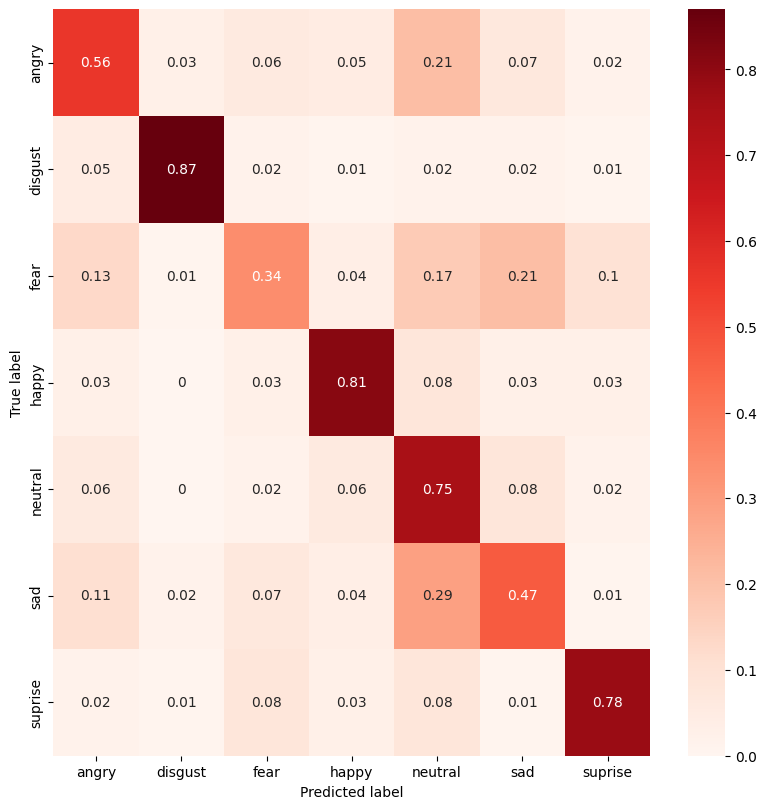

In [76]:
y_predict = model.predict(X_test_raf)
y_true = y_test_raf
res = tf.math.confusion_matrix(y_true, y_predict.argmax(axis = 1)).numpy()
class_names = ["angry", "disgust", "fear", "happy", "neutral", "sad", "suprise"]
con_mat_norm = np.around(res.astype('float')/res.sum(axis = 1)[:, np.newaxis], decimals = 2)
con_mat_df = pd.DataFrame(con_mat_norm, index = class_names, columns = class_names)

figure = plt.figure(figsize = (8,8))
sns.heatmap(con_mat_df, annot = True, cmap = plt.cm.Reds)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [77]:
y_test_raf = tf.keras.utils.to_categorical(y_test_raf, num_classes = 7)
model.evaluate(X_test_raf, y_test_raf)

221/221 [==============================] - 3s 16ms/step - loss: 0.9741 - acc: 0.6404


[0.9740688800811768, 0.6403905749320984]

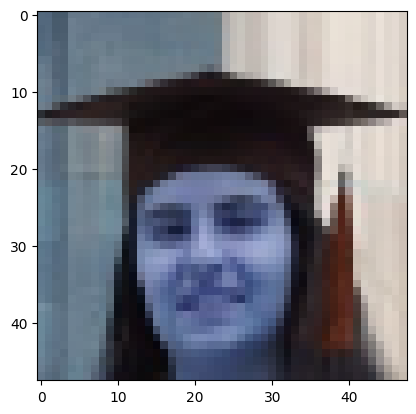

In [81]:
image = cv2.imread("/kaggle/input/image-sample/graduation_two.png")
image = cv2.resize(image, (48, 48))
plt.imshow(image)

In [83]:
dict_label = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprise" }
test_img = np.expand_dims(image, axis = 0)
test_img = test_img.reshape(1, 48, 48, 3)

In [84]:
result = model.predict(test_img)
result = list(result[0])
img_index = result.index(max(result))
print(dict_label[img_index])

1/1 [==============================] - 0s 483ms/step
Neutral
